In [1]:
import sys
sys.path.append('..')
# reload local packages automatically
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)

# Import packages.
import cvxpy as cp
import numpy as np

import matplotlib.pyplot as plt

from opentn.transformations import create_kitaev_liouvillians, exp_operator_dt, factorize_psd, super2choi, choi_composition
from opentn.optimization import small2zero, gds, frobenius_norm, model_Ys, compute_loss


d, N = 2, 4
gamma = 1
dim = d**N
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=gamma)
tau = 4
superops_exp = []
for i, op in enumerate([Lvec, Lvec_odd, Lvec_even]):
    if i == 1:
        superops_exp.append(exp_operator_dt(op, tau/2, 'jax'))
    else:
        superops_exp.append(exp_operator_dt(op, tau, 'jax'))
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = superops_exp

tol = 1e-12

# show here a plot with the comparison from initial gds -> cvx -> gds
X1 = factorize_psd(psd=super2choi(exp_Lvec_odd), tol=tol)
X2 = factorize_psd(psd=super2choi(exp_Lvec_even), tol=tol)

0.09591767023235205
0.05304431675567806


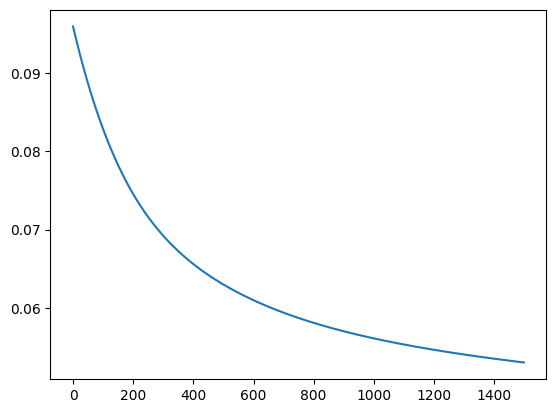

In [2]:
from opentn.optimization import gds, frobenius_norm, model_Ys, compute_loss
cost_first_opt, _, xi_first_opt = gds(fn=compute_loss, x0=[X1, X2, X1], iter=int(1.5e3), loss_fn=frobenius_norm, model=model_Ys, rate=1e-5, exact = exp_Lvec, show_cost=False)
print(cost_first_opt[0])
print(cost_first_opt[-1])
plt.plot(cost_first_opt)

In [71]:
# DETOUR: I need to check if the maps we are working with are trace preserving:
from opentn.transformations import super2choi, partial_trace
I = np.eye(dim)

Y1_original = X1@X1.conj().T
Y2_original = X2@X2.conj().T

X1_gds, X2_gds, X3_gds = xi_first_opt[-1]
Y1_gds = X1_gds@X1_gds.conj().T
Y2_gds = X2_gds@X2_gds.conj().T
Y3_gds = X3_gds@X3_gds.conj().T

norm_differences = []

for op in [exp_Lvec, exp_Lvec_odd, exp_Lvec_even]:
    print(np.allclose(I, partial_trace(op=super2choi(op), dims=[dim]*2, idx=0)))
    norm = np.linalg.norm(I - partial_trace(op=super2choi(op), dims=[dim]*2, idx=0))
    print(norm)
    norm_differences.append(norm)

print('---')

for op in [Y1_original, Y2_original, Y1_gds, Y2_gds, Y3_gds]:
    print(np.allclose(I, partial_trace(op=op, dims=[dim]*2, idx=0), atol=1e-8))
    norm = np.linalg.norm(I - partial_trace(op=op, dims=[dim]*2, idx=0))
    print(norm)
    norm_differences.append(norm)

True
4.577566798522237e-16
True
6.280369834735101e-16
True
0.0
---
True
1.6355371060249757e-15
True
1.9557512526565554e-15
False
0.0054505249312979
False
0.006800226846540737
False
0.013626929878420072


In [4]:
for op in [Y1_original, Y2_original, Y1_gds, Y2_gds, Y3_gds]:
    reduced = partial_trace(op=op, dims=[dim]*2, idx=0)
    print(np.diag(reduced))
    print('nonzero elements:', np.count_nonzero(reduced[~np.eye(reduced.shape[0],dtype=bool)]))
    print('-----')
# op =  partial_trace(op=Y1_gds, dims=[dim]*2, idx=0)
# mask = (op!=1) & (op!=0)
# len(op[mask]), np.max(op[mask]), np.min(op[mask]), np.where(op > 0, op, np.inf).min(), np.where(op < 0, op, -np.inf).max(), np.linalg.norm(I - op)


[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
nonzero elements: 58
-----
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
nonzero elements: 10
-----
[1.00004302+0.j 1.00009968+0.j 0.99937037+0.j 0.99940686+0.j
 0.99937037+0.j 0.99958829+0.j 1.00018383+0.j 1.00009968+0.j
 1.00009968+0.j 1.00018383+0.j 0.99958829+0.j 0.99937037+0.j
 0.99940686+0.j 0.99937037+0.j 1.00009968+0.j 1.00004302+0.j]
nonzero elements: 122
-----
[1.00004302+0.j 0.99930065+0.j 1.00016941+0.j 0.99940543+0.j
 1.00016941+0.j 1.00069713+0.j 0.99907645+0.j 0.99930065+0.j
 0.99930065+0.j 0.99907645+0.j 1.00069713+0.j 1.00016941+0.j
 0.99940543+0.j 1.00016941+0.j 0.99930065+0.j 1.00004302+0.j]
nonzero elements: 122
-----
[1.00004302+0.j 0.99930214+0.j 1.00016792+0.j 0.99880453+0.j
 1.00016792+0.j 1.00129594+0.j 0.99907854+0.j 0.99930214+0.j
 0.99930214+0.j 0.99907854+0.j 1.00129594+0.j 1.

In [40]:
# rhs to which we want to approximate
rhs = np.asarray(super2choi(superop=exp_Lvec, dim=dim))

In [41]:
for op in [rhs, X1, X2]:
    rank = np.linalg.matrix_rank(op)
    print('rank:', rank)
    print('singular values:', np.linalg.svd(op, compute_uv=False)[:rank+8])
    op = small2zero(op, tol)
    rank = np.linalg.matrix_rank(op)
    print('rank:', rank)
    print('singular values:', np.linalg.svd(op, compute_uv=False)[:rank+8])
    print('-----')

rank: 55
singular values: [9.53641715e+00 2.19659719e+00 1.83705318e+00 1.23340484e+00
 3.96335140e-01 2.02486307e-01 2.02168838e-01 1.68405942e-01
 1.03484948e-01 3.04312181e-02 2.71458005e-02 1.98597321e-02
 1.61054875e-02 7.11813227e-03 5.71624218e-03 3.61692408e-03
 3.43655437e-03 1.94016912e-03 1.41865742e-03 1.20120682e-03
 1.14706844e-03 9.47948373e-04 5.07043675e-04 4.32492475e-04
 3.99225197e-04 3.20930497e-04 2.70341290e-04 2.07665642e-04
 1.94420147e-04 1.72476237e-04 1.42246053e-04 1.40628858e-04
 1.38191056e-04 1.03850638e-04 7.71447501e-05 7.15620939e-05
 6.95698508e-05 6.49678804e-05 5.20300625e-05 3.95035250e-05
 3.57726196e-05 2.69674463e-05 1.98317688e-05 1.56273027e-05
 1.22466634e-05 7.78221824e-06 7.60365810e-06 7.43931145e-06
 7.04309630e-06 5.86933898e-06 5.30272687e-06 2.87945870e-06
 1.46131973e-06 9.71054027e-07 2.38412470e-07 2.06754775e-15
 1.13619473e-15 8.14226211e-16 7.06858684e-16 6.12743342e-16
 5.73394045e-16 4.95634433e-16 4.60926060e-16]
rank: 55
sin

In [44]:
from scipy import sparse
nz_rhs = sparse.csc_matrix(rhs).count_nonzero()
nz_x1 = sparse.csc_matrix(X1).count_nonzero()
nz_x2 = sparse.csc_matrix(X2).count_nonzero()

nz_ops = [nz_x1, nz_x2, nz_rhs]

min_tol = 1
max_tol = 15
tols = [10**(-exponent) for exponent in range(min_tol,max_tol)]

nz_ops_tol = np.zeros(shape=(3,len(tols)))

for i, op in enumerate([X1, X2, rhs]):
    for j, tol in enumerate(tols):
        nz_op_tol = sparse.csc_matrix(small2zero(op, tol)).count_nonzero()
        nz_ops_tol[i, j] = nz_op_tol/nz_ops[i]

rel_errors = np.zeros(shape=(3, len(tols)))
for i, op in enumerate([X1, X2, rhs]):
    for j, tol in enumerate(tols):
        rel_error = np.linalg.norm(small2zero(op, tol) - op)/np.linalg.norm(op)
        rel_errors[i,j] = rel_error

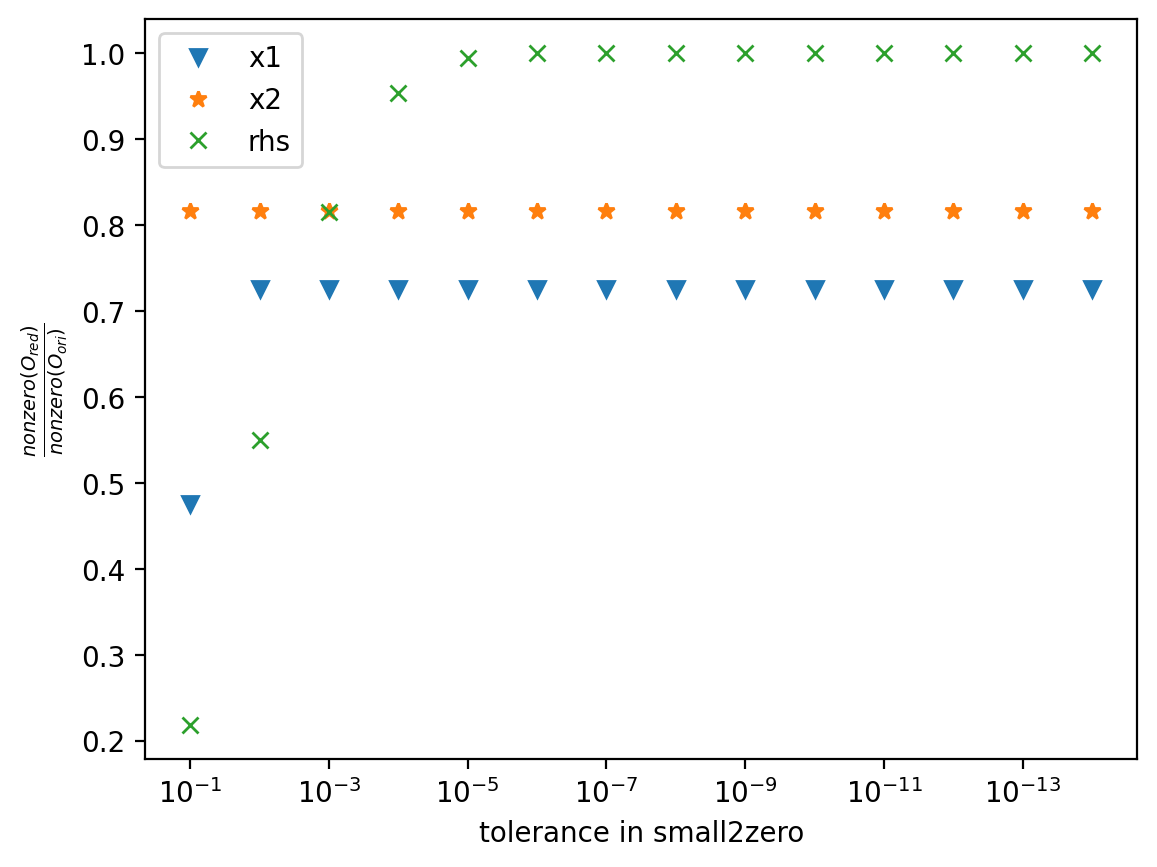

In [45]:
plt.figure(dpi=200)
plt.ylabel(r'$\frac{nonzero(O_{red})}{nonzero(O_{ori})}$')
plt.xlabel('tolerance in small2zero')
plt.semilogx(tols, nz_ops_tol[0,:], 'v' ,label='x1')
plt.semilogx(tols, nz_ops_tol[1,:], '*' ,label='x2')
plt.semilogx(tols, nz_ops_tol[2,:], 'x' ,label='rhs')
plt.legend()
plt.gca().invert_xaxis()

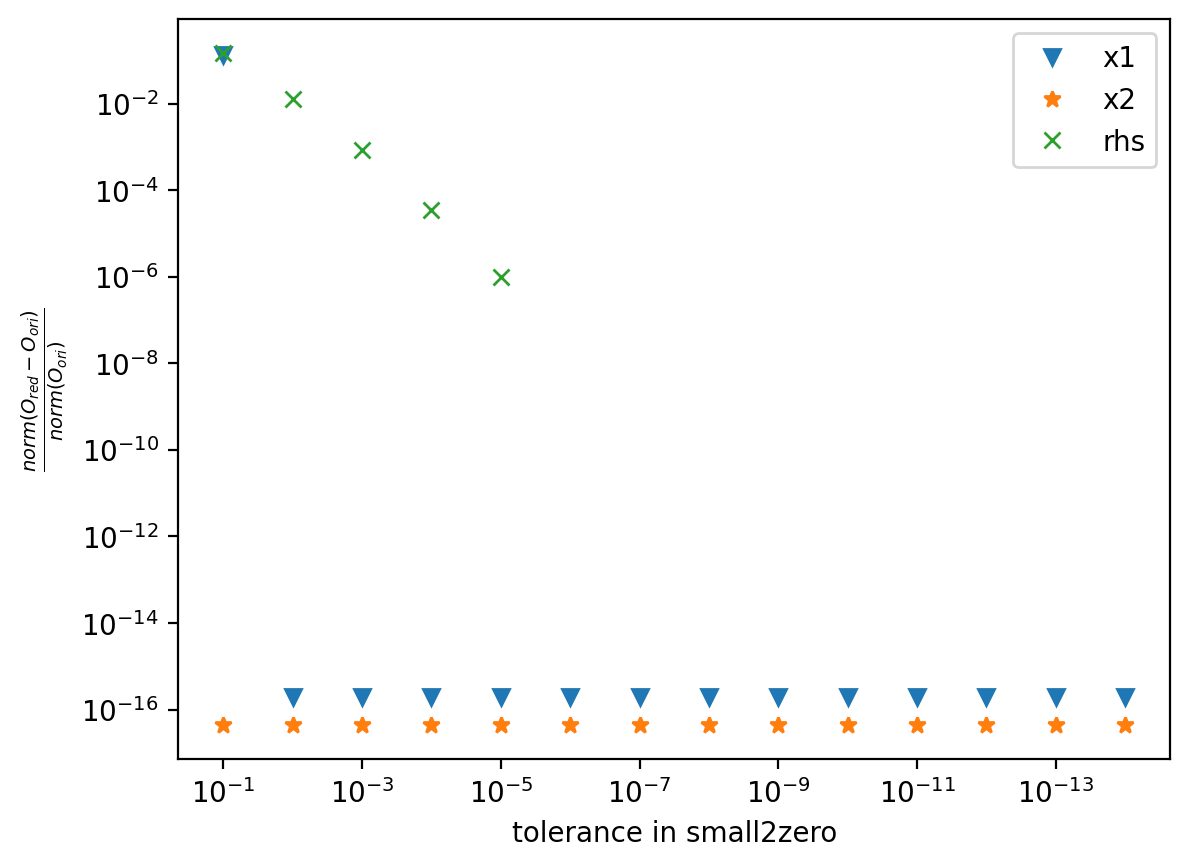

In [48]:
plt.figure(dpi=200)
plt.ylabel(r'$\frac{norm(O_{red} - O_{ori})}{norm(O_{ori})}$')
plt.xlabel('tolerance in small2zero')
plt.loglog(tols, rel_errors[0,:], 'v' ,label='x1')
plt.loglog(tols, rel_errors[1,:], '*' ,label='x2')
plt.loglog(tols, rel_errors[-1,:], 'x' ,label='rhs')
plt.legend()
plt.gca().invert_xaxis()

In [62]:
# now lets see how long would the optimization take 
from opentn.transformations import link_product_cvxpy

tol = 1e-9

# srhs = sparse.csr_matrix(rhs) # small2zero was deleted
srhs = sparse.csr_matrix(small2zero(rhs, tol=tol)) # small2zero was deleted
srhs = srhs.astype(np.float64)

Y1_cvxpy = cp.Variable((dim**2,dim**2), PSD=True)
constraints = [cp.partial_trace(Y1_cvxpy, dims=[dim]*2,axis=0) == I]
C2 = choi_composition(small2zero(Y2_gds, tol), small2zero(Y3_gds, tol))
lhs = link_product_cvxpy(C1=Y1_cvxpy, C2=C2, dim=dim, transpose=1, optimization=True)
cost = cp.norm(lhs - srhs, "fro")
prob = cp.Problem(cp.Minimize(cost), constraints)
Y1_cvxpy.value = small2zero(Y1_gds, tol=tol).astype(np.float64) 
cost.value

/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/scipy/sparse/_data.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  self.data.astype(dtype, casting=casting, copy=True),
/var/folders/lv/986s3mp97gv9n3rb757bg87m0000gn/T/ipykernel_20058/3508442724.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  Y1_cvxpy.value = small2zero(Y1_gds, tol=tol).astype(np.float64)


0.053039674533117996

In [63]:
prob.solve(solver=cp.SCS, verbose=True, canon_backend=cp.SCIPY_CANON_BACKEND, eps=tol)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 01 12:52:01 AM: Your problem has 65536 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 01 12:52:01 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 01 12:52:01 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 01 12:52:01 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 01 12:52:01 AM: Compiling problem (target solver=SCS).
(CVXPY) Aug 01 12:52:01 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

0.044455595752116696

In [72]:
print(np.allclose(I, partial_trace(op=Y1_cvxpy.value, dims=[dim]*2, idx=0), atol=1e-9))
norm = np.linalg.norm(I - partial_trace(op=Y1_cvxpy.value, dims=[dim]*2, idx=0))
norm_differences.append(norm)

True


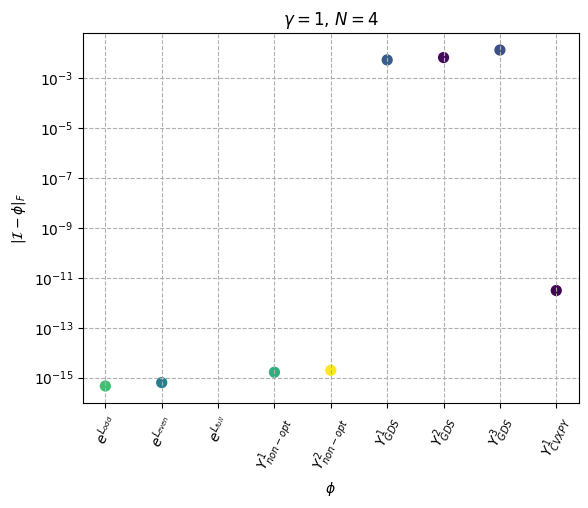

In [73]:
ax = plt.gca()
labels = [r"$e^{L_{odd}}$", r"$e^{L_{even}}$", r"$e^{L_{full}}$", r"$Y^1_{non-opt}$", r"$Y^2_{non-opt}$", r"$Y^1_{GDS}$", r"$Y^2_{GDS}$", r"$Y^3_{GDS}$", r"$Y^1_{CVXPY}$"]
ax.xaxis.set_ticks(np.arange(len(labels)))
ax.xaxis.set_ticklabels(labels, rotation=65)

colors = np.random.uniform(15, 80, len(norm_differences))
ax.scatter(np.arange(len(norm_differences)), norm_differences, c=colors, s=50)
ax.set_yscale('log')

plt.title(f'$\gamma = {gamma}$, $N = {N}$')
plt.xlabel(r"$\phi$")
plt.ylabel(r"$| \mathcal{I} - \phi |_{F}$")
plt.grid(ls='--')

(0.9999999999999993+0j)
True
(0.9999999999999993+0j)
True
(0.9999999999999993+0j)
True
---
(0.9999999999999997+0j)
True
(0.9999999999999996+0j)
True
(0.9999522228427602+0j)
False
(0.9980659638270896+0j)
False
(1.0020662994901812+0j)
False
(1.0000000000000728+0j)
True


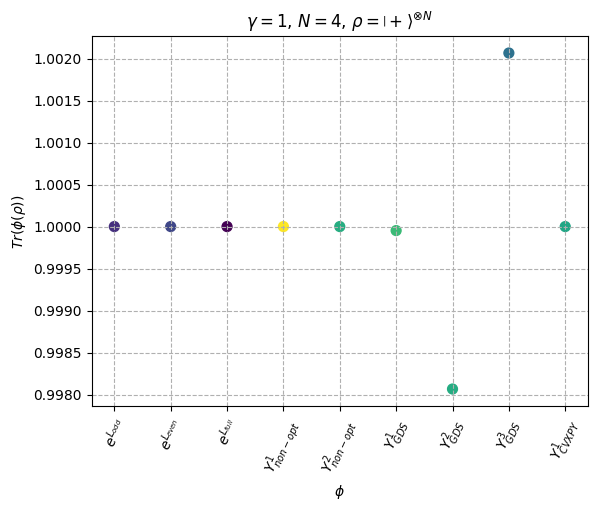

In [75]:
# how much would these actually affect the norm when applied to a denisty matrix
from opentn.states.qubits import plus
from opentn.transformations import ket2dm, vectorize, unvectorize, choi2super
init_state = plus
for i in range(N-1):
    init_state = np.kron(init_state,plus)
init_density = ket2dm(init_state)
init_density_vec = vectorize(init_density)

final_traces = []

# lets apply the operators here and see if the trace is conserved.abs
init_trace = np.trace(init_density)
assert np.allclose(init_trace, 1)

for op in [exp_Lvec, exp_Lvec_odd, exp_Lvec_even]:
    final_density_vec = op@init_density_vec
    final_density = unvectorize(final_density_vec)
    final_trace = np.trace(final_density)
    final_traces.append(final_trace)
    print(final_trace)
    print(np.allclose(final_trace, init_trace))

print('---')

for op in [Y1_original, Y2_original, Y1_gds, Y2_gds, Y3_gds, Y1_cvxpy.value]:
    op = choi2super(op)
    final_density_vec = op@init_density_vec
    final_density = unvectorize(final_density_vec)
    final_trace = np.trace(final_density)
    final_traces.append(final_trace)
    print(final_trace)
    print(np.allclose(final_trace, init_trace))

ax = plt.gca()
labels = [r"$e^{L_{odd}}$", r"$e^{L_{even}}$", r"$e^{L_{full}}$", r"$Y^1_{non-opt}$", r"$Y^2_{non-opt}$", r"$Y^1_{GDS}$", r"$Y^2_{GDS}$", r"$Y^3_{GDS}$", r"$Y^1_{CVXPY}$"]
ax.xaxis.set_ticks(np.arange(len(labels)))
ax.xaxis.set_ticklabels(labels, rotation=65)

colors = np.random.uniform(15, 80, len(final_traces))
ax.scatter(np.arange(len(final_traces)), final_traces, c=colors, s=50)
plt.title(f'$\gamma = {gamma}$, $N = {N}$, ' + r'$\rho = \left| + \right\rangle^{\otimes N}$')
plt.xlabel(r"$\phi$")
plt.ylabel(r"$ Tr(\phi(\rho)) $")
plt.grid(ls='--')
plt.show()

In [87]:
for op in [Y1_cvxpy.value, super2choi(exp_Lvec), super2choi(exp_Lvec_odd), super2choi(exp_Lvec_odd)]:
    op = small2zero(op, tol)
    rank = np.linalg.matrix_rank(op, tol)
    print('rank:', rank)
    print('min neg: ', np.where(op < 0, op, -np.inf).max())
    print('min pos:', np.where(op > 0, op, np.inf).min()) # finding the minimum positive value!
    print('max:', np.max(op))
    print('norm:', np.linalg.norm(op, 'fro'))
    print(f'norm from highest {rank//2} singular values:', np.sqrt(np.sum(np.linalg.svd(op, compute_uv=False)[:rank//2]**2)))
    print(np.linalg.svd(op, compute_uv=False))
    print('----')

rank: 10
min neg:  -6.062557812738028e-07
min pos: 8.438469024542454e-07
max: 1.0000000005603813
norm: 13.154892496219572
norm from highest 5 singular values: 13.154876577708396
[1.30059241e+001 1.39195687e+000 1.39164054e+000 1.48731546e-001
 1.97221743e-002 1.35407307e-002 1.08590216e-002 7.66770814e-003
 7.12046476e-003 2.83687319e-003 7.47485152e-010 7.43130511e-010
 7.09701410e-010 7.04043545e-010 6.91383491e-010 6.72314139e-010
 4.49954485e-010 4.46067352e-010 4.30829192e-010 4.29039792e-010
 3.98702323e-010 3.89656689e-010 3.83154485e-010 3.81451452e-010
 3.49497069e-010 3.46754741e-010 3.17044543e-010 3.01206883e-010
 2.89634969e-010 2.86090203e-010 2.82641619e-010 2.70271819e-010
 2.67056438e-010 2.47579617e-010 2.46310964e-010 2.45264133e-010
 2.41317081e-010 2.07858816e-010 1.94330013e-010 1.93083999e-010
 1.72347800e-010 1.71288531e-010 1.66074150e-010 1.59041488e-010
 1.51774534e-010 1.51114795e-010 1.50746983e-010 1.44531167e-010
 1.38469932e-010 1.30311235e-010 1.2821289

In [92]:
with open(f'Y1_scs_warm_gds_eps_{tol}_TP_gamma_{gamma}.npy', 'wb') as f:
    np.save(f, Y1_cvxpy.value)

In [89]:
Y3_cvxpy = cp.Variable((dim**2,dim**2), PSD=True)
lhs_Y3 = link_product_cvxpy(C1=choi_composition(small2zero(Y1_cvxpy.value, tol), small2zero(Y2_gds, tol)), C2=Y3_cvxpy, dim=dim, transpose=0, optimization=True)
constraints_Y3 = [cp.partial_trace(Y3_cvxpy, dims=[dim]*2,axis=0) == I]
cost_Y3 = cp.norm(lhs_Y3 - srhs, "fro")
prob_Y3 = cp.Problem(cp.Minimize(cost_Y3), constraints_Y3)
Y3_cvxpy.value = small2zero(Y3_gds, tol=tol).astype(np.float64) 
cost_Y3.value

/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/scipy/sparse/_data.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  self.data.astype(dtype, casting=casting, copy=True),
/var/folders/lv/986s3mp97gv9n3rb757bg87m0000gn/T/ipykernel_20058/1895369184.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  Y3_cvxpy.value = small2zero(Y3_gds, tol=tol).astype(np.float64)


0.04445559575211643

In [90]:
prob_Y3.solve(solver=cp.SCS, verbose=True, canon_backend=cp.SCIPY_CANON_BACKEND, eps=tol)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 02 01:32:55 PM: Your problem has 65536 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 02 01:32:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 02 01:32:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 02 01:32:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 02 01:32:55 PM: Compiling problem (target solver=SCS).
(CVXPY) Aug 02 01:32:55 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

0.04123424653946197

In [91]:
with open(f'Y3_scs_warm_gds_eps_{tol}_TP_gamma_{gamma}.npy', 'wb') as f:
    np.save(f, Y3_cvxpy.value)

In [93]:
# now we optimize the second layer
Y2_cvxpy = cp.Variable((dim**2,dim**2), PSD=True)
constraints_Y2 = [cp.partial_trace(Y2_cvxpy, dims=[dim]*2,axis=0) == I]
C12 = link_product_cvxpy(C1=small2zero(Y1_cvxpy.value, tol), C2=Y2_cvxpy, dim=dim, transpose=0, optimization=True)
lhs_Y2 = link_product_cvxpy(C1=C12, C2=small2zero(Y3_cvxpy.value, tol), dim=dim, transpose=1, optimization=True)
cost_Y2 = cp.norm(lhs_Y2 - srhs, "fro")
prob_Y2 = cp.Problem(cp.Minimize(cost_Y2), constraints_Y2)
Y2_cvxpy.value = small2zero(Y2_gds, tol=tol).astype(np.float64) 
cost_Y2.value

/var/folders/lv/986s3mp97gv9n3rb757bg87m0000gn/T/ipykernel_20058/4099231669.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  Y2_cvxpy.value = small2zero(Y2_gds, tol=tol).astype(np.float64)


0.041234246539461755

In [94]:
prob_Y2.solve(solver=cp.SCS, verbose=True, canon_backend=cp.SCIPY_CANON_BACKEND, eps=tol)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 02 02:09:29 PM: Your problem has 65536 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 02 02:09:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 02 02:09:29 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 02 02:09:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 02 02:09:29 PM: Compiling problem (target solver=SCS).
(CVXPY) Aug 02 02:09:29 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

0.03709461354660242

In [95]:
with open(f'Y2_scs_warm_gds_eps_{tol}_TP_gamma_{gamma}.npy', 'wb') as f:
    np.save(f, Y2_cvxpy.value)

In [103]:

Y1_cvxpy_2 = cp.Variable((dim**2,dim**2), PSD=True)
constraints = [cp.partial_trace(Y1_cvxpy_2, dims=[dim]*2,axis=0) == I]
C2 = choi_composition(small2zero(Y2_cvxpy.value, tol), small2zero(Y3_cvxpy.value, tol))
lhs = link_product_cvxpy(C1=Y1_cvxpy_2, C2=C2, dim=dim, transpose=1, optimization=True)
cost = cp.norm(lhs - srhs, "fro")
prob = cp.Problem(cp.Minimize(cost), constraints)
Y1_cvxpy_2.value = small2zero(Y1_cvxpy.value, tol=tol).astype(np.float64) 
cost.value

0.03709461354660139

In [104]:
prob.solve(solver=cp.SCS, verbose=True, canon_backend=cp.SCIPY_CANON_BACKEND, eps=tol)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 04 07:40:09 PM: Your problem has 65536 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 04 07:40:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 04 07:40:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 04 07:40:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 04 07:40:09 PM: Compiling problem (target solver=SCS).
(CVXPY) Aug 04 07:40:09 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

0.03374274538011153

In [106]:
with open(f'Y1_scs_warm_gds_eps_{tol}_TP_gamma_{gamma}_2.npy', 'wb') as f:
    np.save(f, Y1_cvxpy_2.value)

In [105]:
 0.03709461354660242/cost_first_opt[0], 0.03374274538011153/cost_first_opt[0]

(Array(0.38673389, dtype=float64), Array(0.35178863, dtype=float64))

In [108]:
Y2_cvxpy_2 = cp.Variable((dim**2,dim**2), PSD=True)
constraints_Y2 = [cp.partial_trace(Y2_cvxpy_2, dims=[dim]*2,axis=0) == I]
C12 = link_product_cvxpy(C1=small2zero(Y1_cvxpy_2.value, tol), C2=Y2_cvxpy_2, dim=dim, transpose=0, optimization=True)
lhs_Y2 = link_product_cvxpy(C1=C12, C2=small2zero(Y3_cvxpy.value, tol), dim=dim, transpose=1, optimization=True)
cost_Y2 = cp.norm(lhs_Y2 - srhs, "fro")
prob_Y2 = cp.Problem(cp.Minimize(cost_Y2), constraints_Y2)
Y2_cvxpy_2.value = small2zero(Y2_cvxpy.value, tol=tol).astype(np.float64) 
cost_Y2.value

0.03374274538010897

In [109]:
prob_Y2.solve(solver=cp.SCS, verbose=True, canon_backend=cp.SCIPY_CANON_BACKEND, eps=tol)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 04 08:42:42 PM: Your problem has 65536 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 04 08:42:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 04 08:42:42 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 04 08:42:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 04 08:42:42 PM: Compiling problem (target solver=SCS).
(CVXPY) Aug 04 08:42:42 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

0.03334022452187357

In [117]:
with open(f'Y2_scs_warm_gds_eps_{tol}_TP_gamma_{gamma}_2.npy', 'wb') as f:
    np.save(f, Y2_cvxpy_2.value)

In [118]:
Y3_cvxpy_2 = cp.Variable((dim**2,dim**2), PSD=True)
lhs_Y3 = link_product_cvxpy(C1=choi_composition(small2zero(Y1_cvxpy_2.value, tol), small2zero(Y2_cvxpy_2.value, tol)), C2=Y3_cvxpy_2, dim=dim, transpose=0, optimization=True)
constraints_Y3 = [cp.partial_trace(Y3_cvxpy_2, dims=[dim]*2,axis=0) == I]
cost_Y3 = cp.norm(lhs_Y3 - srhs, "fro")
prob_Y3 = cp.Problem(cp.Minimize(cost_Y3), constraints_Y3)
Y3_cvxpy_2.value = small2zero(Y3_cvxpy.value, tol=tol).astype(np.float64) 
print(cost_Y3.value)

0.033340224521868904


In [119]:
prob_Y3.solve(solver=cp.SCS, verbose=True, canon_backend=cp.SCIPY_CANON_BACKEND, eps=tol)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 07 01:13:07 PM: Your problem has 65536 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 07 01:13:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 07 01:13:07 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 07 01:13:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 07 01:13:07 PM: Compiling problem (target solver=SCS).
(CVXPY) Aug 07 01:13:07 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

0.03147801872934154

In [121]:
with open(f'Y3_scs_warm_gds_eps_{tol}_TP_gamma_{gamma}_2.npy', 'wb') as f:
    np.save(f, Y3_cvxpy_2.value)

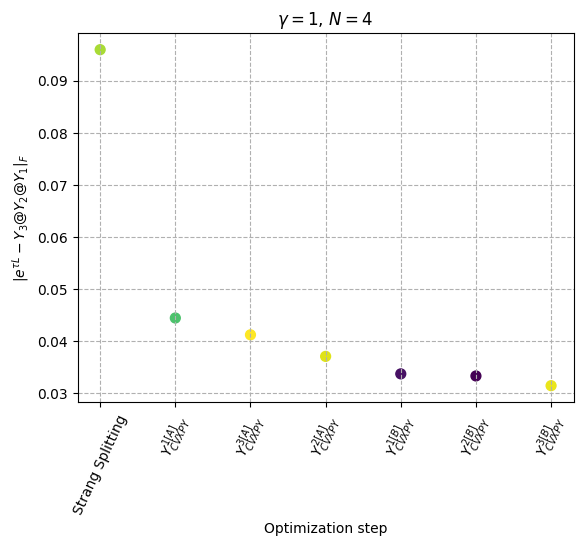

In [120]:
# cost function graph
cost_list = [cost_first_opt[0], 0.044455595752116696, 0.04123424653946197, 0.03709461354660242, 0.03374274538011153, 0.03334022452187357, 0.03147801872934154]

ax = plt.gca()
labels = [r"Strang Splitting" ,r"$Y^{1[A]}_{CVXPY}$", r"$Y^{3[A]}_{CVXPY}$", r"$Y^{2[A]}_{CVXPY}$", r"$Y^{1[B]}_{CVXPY}$", r"$Y^{2[B]}_{CVXPY}$", r"$Y^{3[B]}_{CVXPY}$"]
ax.xaxis.set_ticks(np.arange(len(labels)))
ax.xaxis.set_ticklabels(labels, rotation=65)

colors = np.random.uniform(15, 80, len(cost_list))
ax.scatter(np.arange(len(cost_list)), cost_list, c=colors, s=50)
plt.title(f'$\gamma = {gamma}$, $N = {N}$ ')
plt.xlabel("Optimization step")
plt.ylabel(r"$ | e^{\tau L} - Y_3 @ Y_2 @ Y_1 |_F $")
plt.grid(ls='--')
plt.show()